Dataset carregado: 1550 registos limpos.

--- Atraso por Região ---
          Taxa de Atraso  Qtd Pedidos
Region                               
Sudeste         0.835025          394
Sul             0.826531          392
Norte           0.825737          373
Nordeste        0.823529          391


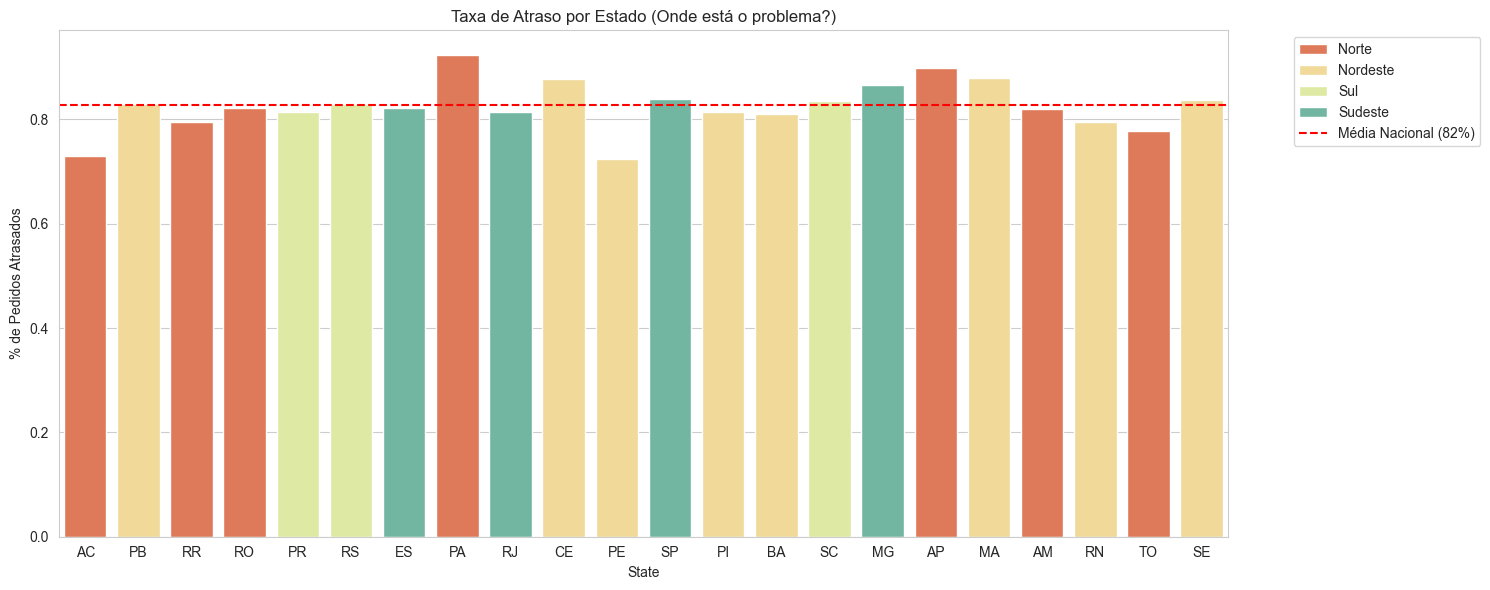

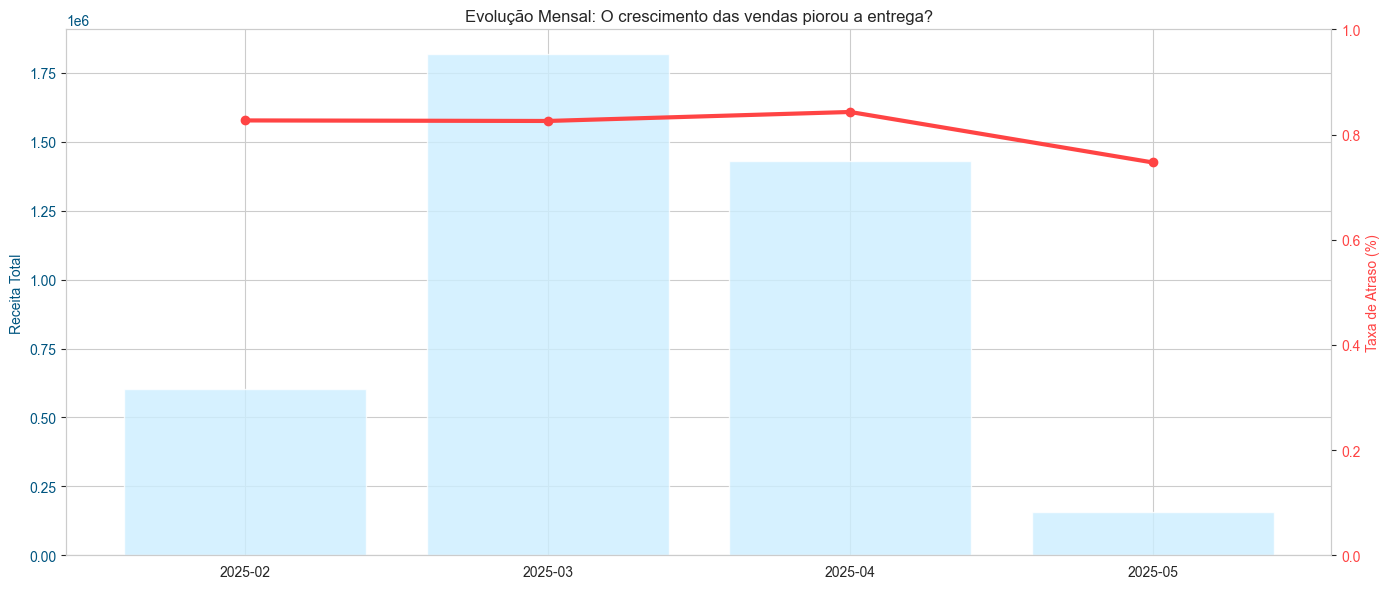

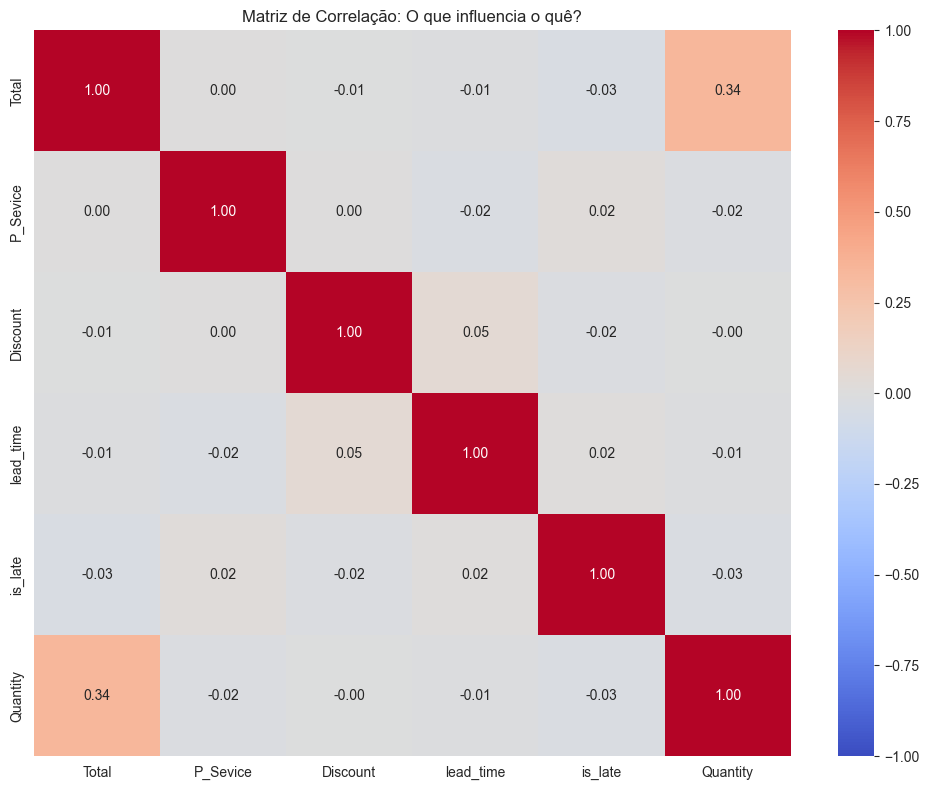

In [1]:
# --- CÉLULA 1: Setup e Carregamento (Reutilizando o Limpo) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configs Visuais
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Carregar o dataset JÁ SANEADO (que criamos no passo anterior)
# Se der erro, verifique se o arquivo existe em data/processed/
try:
    df = pd.read_csv('../data/processed/orders_saneado.csv')

    # Garantir datetime (CSV perde essa info ao salvar)
    df['Order_Date'] = pd.to_datetime(df['Order_Date'])
    df['D_Date'] = pd.to_datetime(df['D_Date'])

    print(f"Dataset carregado: {len(df)} registos limpos.")
except FileNotFoundError:
    print("ERRO: Execute o notebook 01 primeiro para gerar o arquivo saneado.")

# --- CÉLULA 2: Análise Geográfica (O Mapa do Atraso) ---
# Agrupar por Estado
geo_analysis = df.groupby('Region')['is_late'].agg(['mean', 'count']).sort_values('mean', ascending=False)
geo_analysis.columns = ['Taxa de Atraso', 'Qtd Pedidos']

print("\n--- Atraso por Região ---")
print(geo_analysis)

# Gráfico de Atraso por Estado
plt.figure(figsize=(15, 6))
sns.barplot(
    x='State',
    y='is_late',
    data=df,
    hue='Region',  # Colorir por Região para facilitar a leitura
    errorbar=None,
    palette='Spectral'
)
plt.axhline(y=df['is_late'].mean(), color='red', linestyle='--', label='Média Nacional (82%)')
plt.title('Taxa de Atraso por Estado (Onde está o problema?)')
plt.ylabel('% de Pedidos Atrasados')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Salvar
if not os.path.exists('../reports/figures'):
    os.makedirs('../reports/figures')
plt.savefig('../reports/figures/geo_atraso.png')
plt.show()

# --- CÉLULA 3: Sazonalidade (Tendência Mensal) ---
# Criar coluna de Mês
df['Mes'] = df['Order_Date'].dt.to_period('M')

trend = df.groupby('Mes').agg({
    'Total': 'sum',
    'is_late': 'mean',
    'lead_time': 'mean'
})

# Plot duplo (Receita vs Atraso)
fig, ax1 = plt.subplots(figsize=(14, 6))

# Barras de Receita
ax1.bar(trend.index.astype(str), trend['Total'], color='#cceeff', label='Receita (R$)', alpha=0.8)
ax1.set_ylabel('Receita Total', color='#005580')
ax1.tick_params(axis='y', labelcolor='#005580')

# Linha de Atraso
ax2 = ax1.twinx()
ax2.plot(trend.index.astype(str), trend['is_late'], color='#ff4444', marker='o', linewidth=3, label='Taxa de Atraso')
ax2.set_ylabel('Taxa de Atraso (%)', color='#ff4444')
ax2.set_ylim(0, 1) # Escala 0 a 100%
ax2.tick_params(axis='y', labelcolor='#ff4444')

plt.title('Evolução Mensal: O crescimento das vendas piorou a entrega?')
plt.grid(False) # Limpar o grid para não poluir
plt.tight_layout()

plt.savefig('../reports/figures/sazonalidade_trend.png')
plt.show()

# --- CÉLULA 4: A Correlação do Caos (Heatmap) ---
# Vamos correlacionar apenas colunas numéricas relevantes
cols_corr = ['Total', 'P_Sevice', 'Discount', 'lead_time', 'is_late', 'Quantity']
corr = df[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt=".2f")
plt.title('Matriz de Correlação: O que influencia o quê?')
plt.tight_layout()

plt.savefig('../reports/figures/heatmap_correlacao.png')
plt.show()